<font color = 'red'> Set p-value threshold in backward elimination. Make k-fold cross validation. Also try lasso after lasso.

# DREAM Preterm Birth Prediction challenge

This is analysis of data competition "DREAM Preterm Birth Prediction challenge". The goal is to predict the gestational age, the months from the last period after pregnancy and the child birth, based on the blood genome data. The main difficulty is to extract important features from the data, which has 30,000 columns.

# Package

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statistics
import math
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers

# Data 

The following data was preprocessed in R, by merging eset_HTA20 and anoSC1_v11_nokey.csv. It contains both train and test observations.

In [3]:
alldata = pd.read_csv("alldata.csv")
alldata.head()

,Unnamed: 0,g_1,g_2,g_3,g_4,g_5,g_6,g_7,g_8,g_9,...,g_32827,g_32828,g_32829,g_32830,SampleID,GA,Batch,Set,Train,Platform
0,1,6.062215,3.796484,5.849338,3.567779,6.166815,4.443027,5.836522,6.330018,4.922339,...,8.972873,10.440245,12.101476,13.695705,Tarca_001_P1A01,11.0,1,PRB_HTA,1,HTA20
1,2,6.125023,3.805305,6.191562,3.452524,5.678373,4.773199,6.143398,5.601745,4.711765,...,9.376194,10.845176,12.370891,13.635522,Tarca_003_P1A03,NaN,1,PRB_HTA,0,HTA20
2,3,5.875502,3.450245,6.550525,3.316134,6.185059,4.393488,5.898364,6.137984,4.628124,...,8.843612,10.493416,12.295786,13.616688,Tarca_004_P1A04,32.6,1,PRB_HTA,1,HTA20
3,4,6.126131,3.628411,6.421877,3.432451,5.633757,4.623783,6.019792,5.787502,4.796283,...,9.191471,10.879879,12.249936,13.524328,Tarca_005_P1A05,30.6,1,PRB_HTA,1,HTA20
4,5,6.146466,3.446812,6.260962,3.477162,5.313198,4.422651,6.407699,5.830437,4.726488,...,9.247768,10.754316,12.245458,13.509353,Tarca_006_P1A06,NaN,1,PRB_HTA,0,HTA20


# Train and test split

In [4]:
X_train_df = alldata.loc[alldata['Train'] == 1, 'g_1':'g_32830']
y_train_df = alldata.loc[alldata['Train'] == 1, 'GA']
X_test_df = alldata.loc[alldata['Train'] == 0, 'g_1':'g_32830']
ID_test_df = alldata.loc[alldata['Train'] == 0, 'SampleID']
print("X_train dimension:", X_train_df.shape)
print("y_train dimension:", y_train_df.shape)
print("X_test dimension:", X_test_df.shape)

X_train dimension: (367, 32830)
y_train dimension: (367,)
X_test dimension: (368, 32830)


# Principal components analysis

In [5]:
scaler = StandardScaler()
scaler.fit(X_train_df)
X_train_scaled = scaler.transform(X_train_df)

In [6]:
pca = PCA()
pca.fit(X_train_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [25]:
sum(pca.explained_variance_ratio_[0:150])

0.8008095329277931

In [33]:
pca_2 = PCA(0.8)
pca_2.fit(X_train_scaled)
print(sum(pca_2.explained_variance_ratio_))
print(pca_2.n_components_)

0.8008095329277931
150


In [34]:
X_train_pca = pca_2.transform(X_train_scaled)
X_train_pca.shape

(367, 150)

By PCA, training data dimension reduced from 32,830 to 150, which explained 80% of total variance.

# Lasso

Tuned lasso regression hyperparameters: {'alpha': 0.024}
Best score: 0.30
RMSE: 5.82
Number of predictors: 41


C:\Users\yukic\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


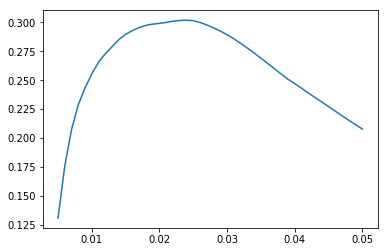

In [38]:
k = 10
alpha_lower = 0.005
alpha_upper = 0.05

# Setup the parameter grid
alpha_space = np.arange(alpha_lower, alpha_upper, 0.001)
param_grid = {'alpha':alpha_space}

# Instantiate a lasso regression
lasso = Lasso(normalize = True)

# Instantiate the GridSearchCV object
lasso_cv = GridSearchCV(lasso, param_grid, cv = k)

# Fit it to data
lasso_cv.fit(X_train_pca, y_train_df.values)

# Calculate training accuracy by RMSE
y_pred = lasso_cv.predict(X_train_pca)
rmse = math.sqrt(statistics.mean((y_train_df.values - y_pred)**2))

# Predictors
best_alpha = lasso_cv.best_params_['alpha']
lasso = Lasso(alpha = best_alpha, normalize = True)
lasso.fit(X_train_pca, y_train_df.values)
lasso_coef = lasso.coef_
p = sum(abs(lasso_coef) > 0)

# Print the tuned parameters and score
print("Tuned lasso regression hyperparameters: {}".format(lasso_cv.best_params_))
print("Best score: {0:.2f}".format(lasso_cv.best_score_))
print("RMSE: {0:.2f}".format(rmse))
print("Number of predictors: {}".format(p))

# Check alpha and score
_ = plt.plot(alpha_space, lasso_cv.cv_results_['mean_test_score'])
plt.show()

After lasso variable selection, we still have 41 variables, which is not much different from lasso variable selection without PCA.